In [1]:
from exp.expdata import LotkaVolterraExp
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import jax.numpy as jnp
import jax
jax.config.update('jax_enable_x64',True)

In [2]:
noise=0.5
noise = 0.2
dt_train = 5.555
dt_train = 5.376
dt_train = 5.5 # from est_period / 2 + epsish
# dt_train = 5.6
t1=97.
t1=46.
t1=100.
# t1 = 300.
# t1=50.
expdata = LotkaVolterraExp(t0=0.,t1=t1,noise=noise, dt_train=dt_train,n_colloc=500, feature_names=['x','y'],seed=1234)

In [3]:
extra_t_train= jnp.linspace(0,1,5)[1:]
expdata.t_train = jnp.hstack([expdata.t_train,extra_t_train])
expdata.x_train = jnp.vstack([expdata.x_train,jax.vmap(expdata.system_sol.evaluate)(extra_t_train)])

x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape

(23,)

In [4]:
x_train

Array([[10.24820849,  5.0240378 ],
       [ 0.41091366,  1.61782553],
       [ 7.89570795,  5.31157354],
       [ 1.03713587,  1.64772158],
       [ 6.36609693,  5.84713211],
       [ 1.27941514,  1.22527718],
       [ 4.85319028,  6.15341435],
       [ 1.10721791,  1.19791625],
       [ 3.35183033,  5.85509595],
       [ 1.88882128,  1.02933176],
       [ 2.55036082,  6.18183552],
       [ 1.40295892,  1.31318206],
       [ 1.98897993,  5.86498927],
       [ 2.04294272,  1.11660249],
       [ 1.78191786,  5.70610706],
       [ 2.38676399,  0.98803179],
       [ 1.22452014,  5.2848763 ],
       [ 2.6383161 ,  0.81021414],
       [ 1.14596095,  4.81960882],
       [ 7.71694334,  5.6455093 ],
       [ 5.6531001 ,  6.03265416],
       [ 4.03808608,  6.15533993],
       [ 2.88109331,  6.06742771]], dtype=float64)

In [5]:
def state(t):
    return np.array(expdata.system_sol.evaluate(t))

def loss(p):
    return np.linalg.norm(np.array(expdata.initial_state) - state(p))**2

from scipy.optimize import minimize_scalar
period_sol = minimize_scalar(loss,bounds = (5,15.))
period_est = period_sol.x
period_est /2

np.float64(5.394439184459843)

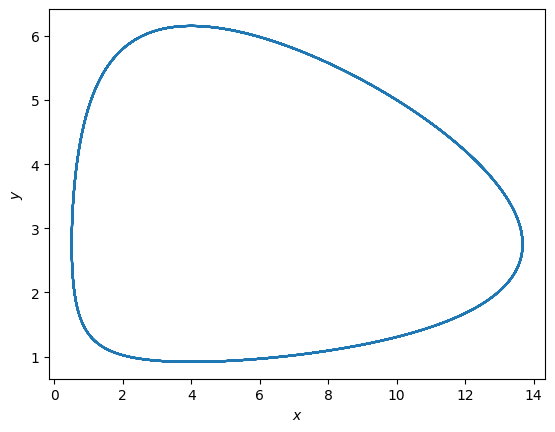

In [6]:
plt.plot(x_true[:,0], x_true[:,1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

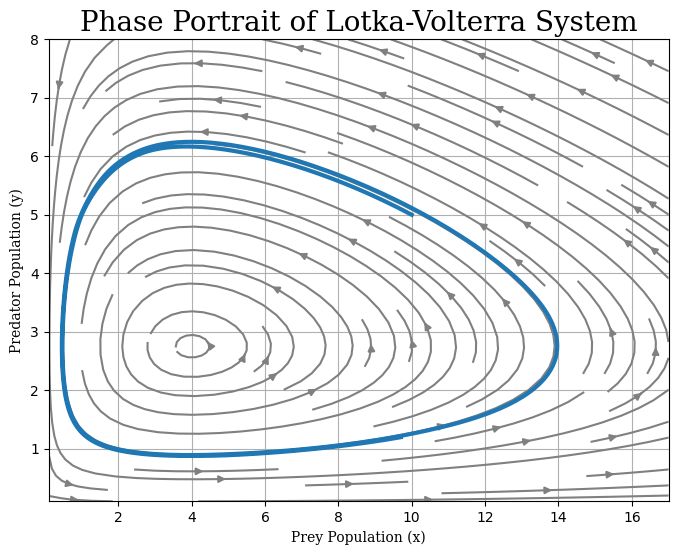

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Lotka-Volterra equations
def lotka_volterra(t, z, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Create a grid of initial conditions
x_vals = np.linspace(0.1, 17, 501)
y_vals = np.linspace(0.1, 8, 501)

X0, Y0 = np.meshgrid(x_vals, y_vals)
U = np.zeros(X0.shape)
V = np.zeros(Y0.shape)

# Evaluate the vector field
for i in range(X0.shape[0]):
    for j in range(X0.shape[1]):
        dxdt, dydt = lotka_volterra(0, [X0[i, j], Y0[i, j]])
        U[i, j] = dxdt
        V[i, j] = dydt

# Normalize the arrows
speed = np.sqrt(U**2 + V**2)
U /= speed
V /= speed

# Plot phase portrait
plt.figure(figsize=(8, 6))
plt.streamplot(x_vals, y_vals, U, V, color='gray')
plt.xlabel('Prey Population (x)',family='serif')
plt.ylabel('Predator Population (y)',family='serif')
plt.title('Phase Portrait of Lotka-Volterra System',family='serif',size=20)

# Overlay a few solution trajectories
initial_conditions = [[10, 5], [2, 1], [1, 2], [3, 3], [4, 1]]

for z0 in initial_conditions[:1]:
    sol = solve_ivp(lotka_volterra, [0, 25], z0, dense_output=True)
    t = np.linspace(0, 20, 1001)
    z = sol.sol(t)
    plt.plot(z[0], z[1], label=rf'$x_0=${z0[0]}, $y_0$={z0[1]}',lw=3)

# plt.legend(prop={'family':'serif'})
plt.grid(True)
plt.savefig("lv_phase_portrait.png")
plt.show()


In [8]:
t_train[-1]+dt_train, t_train

(Array(6.5, dtype=float64),
 Array([ 0.  ,  5.5 , 11.  , 16.5 , 22.  , 27.5 , 33.  , 38.5 , 44.  ,
        49.5 , 55.  , 60.5 , 66.  , 71.5 , 77.  , 82.5 , 88.  , 93.5 ,
        99.  ,  0.25,  0.5 ,  0.75,  1.  ], dtype=float64))

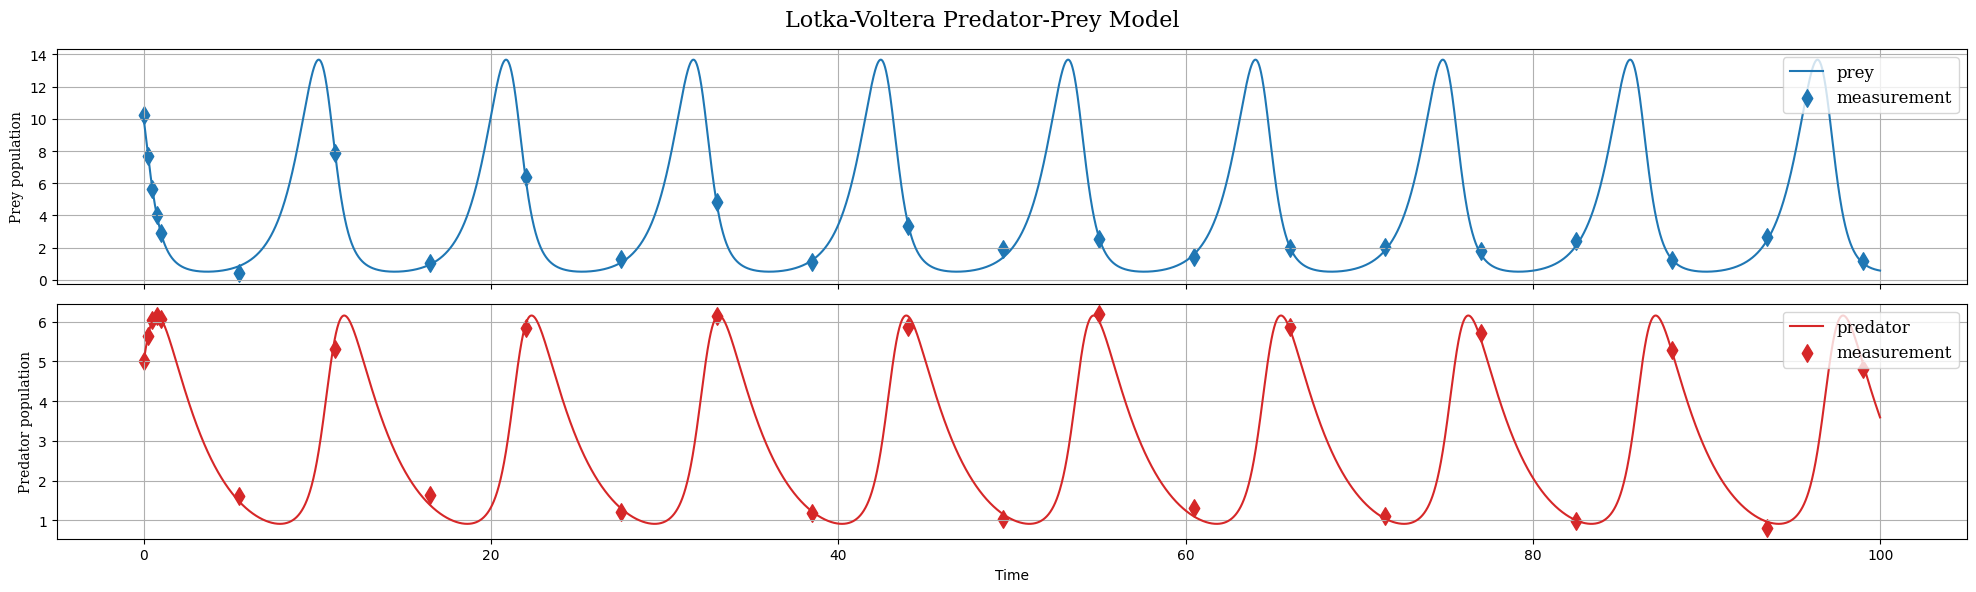

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="prey", c='tab:blue',)
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80)
ax1.set_ylabel("Prey population", fontname=fontname)
ax1.legend(loc='upper right',prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='tab:red', marker='d',s=80)
ax2.set_ylabel("Predator population", fontname=fontname)
ax2.set_xlabel("Time")
ax2.grid(True)
ax2.legend(loc='upper right',prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

$$\dot x = \alpha x - \beta x y$$
$$\dot y = -\gamma y + \delta x y $$

where $\alpha = 1.1$, $\beta = 0.4$, $\gamma  = 0.4$, and $\delta = 0.1$.

In [10]:
expdata.print(precision=1)

(x)' = 1.1 x + -0.4 x y
(y)' = -0.4 y + 0.1 x y


In [11]:
X = x_true[:,0]
t = t_true
dt = t[1]-t[0]

In [12]:
Y = fft(X-np.mean(X))
Y_real = np.real(Y)
Y_imag = np.imag(Y)
freqs = fftfreq(len(t),dt)
pos_mask = freqs > 0
power = np.abs(Y[pos_mask])**2

In [ ]:
peaks, _ = find_peaks(power)

In [ ]:
power[peaks]

In [ ]:
cutoff = -1
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(power[:peaks[cutoff]+10])
for peak in peaks[:cutoff]: 
    ax.axvline(peak, linestyle='--')
ax.grid(True)
ax.set_yscale('log')
plt.show()
# sampling slightly les than half the period

In [ ]:
plt.plot(freqs)
plt.grid(True)
plt.show()
plt.scatter(Y_real[pos_mask],Y_imag[pos_mask],c='tab:blue', label='pos freq')
plt.scatter(Y_real[~pos_mask],Y_imag[~pos_mask],c='tab:red', label = 'neg freq')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

def get_nyquist_info(x, t, trim_start=0):
    # Trim initial time if needed
    mask = t > trim_start
    x = x[mask]
    t = t[mask]

    Y = fft(x - np.mean(x))
    dt = t[1] - t[0]
    freqs = fftfreq(len(t), dt)

    pos_mask = freqs > 0
    pos_freqs = freqs[pos_mask]
    power = np.abs(Y[pos_mask])**2

    f_max = pos_freqs[np.argmax(power)]
    nyquist_fs = 2 * f_max

    return f_max, nyquist_fs, power, pos_freqs


In [ ]:

# Assuming `sol` from earlier
# prey = x_true[:,0]
# t = t_true
# dt = t[1] - t[0]


f_max, nyquist_fs,power, pos_freqs = get_nyquist_info(x_true[:,0],t_true)
f_max2, nyquist_fs2,power2, pos_freqs2 = get_nyquist_info(x_true[:,1],t_true)

print("prey")
print(f"Estimated dominant frequency: {f_max:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs:.3f} s")
print(1/nyquist_fs)

print('predator')
print(f"Estimated dominant frequency: {f_max2:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs2:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs2:.3f} s")

# Optional: Plot spectrum
family = 'serif'

fig, ax1 = plt.subplots(1,1, figsize= (10,5))

tot = len(power)
tot=25
ax1.plot(pos_freqs[:tot], power[:tot], label='prey')
ax1.plot(pos_freqs2[:tot],power2[:tot], c='tab:red', label='predators')
ax1.axvline(f_max, linestyle='-.', c='grey', label='dominant frequnecy')
ax1.set_xlabel("Frequency (Hz)",family=family)
ax1.set_ylabel("Power", family=family)
ax1.set_title("Power Spectrum of Population", family=family)
ax1.legend(prop = {'family': family})
ax1.grid(True)


plt.show()
print(len(power))

# How is nyquist frequency changing over time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram

# Lotka-Volterra parameters
alpha, beta, gamma, delta = 1.1, 0.4, 0.4, 0.1

def lotka_volterra(t, z):
    x, y = z
    return [alpha * x - beta * x * y, delta * x * y - gamma * y]

# Simulate system
x0, y0 = 10, 5
t_end = 1000
t_eval = np.linspace(0, t_end, 4000)
sol = solve_ivp(lotka_volterra, [0, t_end], [x0, y0], t_eval=t_eval)

prey = sol.y[0]
pred = sol.y[1]
t = sol.t
dt = t[1] - t[0]
fs = 1 / dt

# Compute spectrograms
f_prey, t_prey, Sxx_prey = spectrogram(prey, fs=fs, nperseg=256, noverlap=128)
f_pred, t_pred, Sxx_pred = spectrogram(pred, fs=fs, nperseg=256, noverlap=128)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

im1 = ax1.pcolormesh(t_prey, f_prey, Sxx_prey, shading='gouraud', cmap='magma')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_title('Spectrogram of Prey Population')
ax1.set_ylim(0, 0.5)
fig.colorbar(im1, ax=ax1, label='Power')

im2 = ax2.pcolormesh(t_pred, f_pred, Sxx_pred, shading='gouraud', cmap='magma')
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [s]')
ax2.set_title('Spectrogram of Predator Population')
ax2.set_ylim(0, 0.5)
fig.colorbar(im2, ax=ax2, label='Power')

plt.tight_layout()
plt.suptitle('Time-Frequency Analysis of Lotka-Volterra Model', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()


# Learn Model

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel


In [14]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.*500
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [15]:
from exp.evaluate.jsindy import evaluate_jmodel

In [16]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
print()
expdata.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.00109617, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 5000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 3.716e+03, gradnorm = 4.454e+03, alpha = 5.0, improvement_ratio = 0.3662
Iteration 1, loss = 3.48e+03, gradnorm = 3.219e+04, alpha = 9.0, improvement_ratio = 0.06646
Iteration 2, loss = 377.8, gradnorm = 7.886e+04, alpha = 7.5, improvement_ratio = 0.9088
Iteration 3, loss = 117.7, gradnorm = 2.747e+04, alpha = 7.5, improvement_ratio = 0.7418
Iteration 4, loss = 29.93, gradnorm = 2.314e+04, alpha = 6.25, improvement_ratio = 0.9174
Iteration 5, loss = 16.44, gradnorm = 8.51e+03, alpha = 5.208, improvement_ratio = 0.9025
Line Search Failed!
Final Iteration Results
Iteration 114, loss = 1.791, gradnorm = 0.0001683, alpha = 968.0, improvement_ratio = -1.035e+06
Model after smooth warm start
(x)' = 0.755 1 + 1.155 x + -0.360 y + -0.009 x^2 + -0.400 x y + 0.033 y^2
(y)' = -0.986 1 + 0.203 x + 0.219 y + -0.017 x^2 + 0.087 x y + -0.079 y^2
Alternating Activeset Sparsifier
Line search Failed
3 active coeffs changed
Line search Failed
Active set stabilized
Line search Failed
(

{'mse': Array(0.07916605, dtype=float64),
 'rmse': np.float64(0.2813646177913557),
 'mae': np.float64(0.22050121860615282),
 'max_abs_error': np.float64(0.685683132008208),
 'normalized_mse': Array(0.01106947, dtype=float64),
 'relative_l2_error': np.float64(0.10518985348992144)}

In [17]:
expdata.print()

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


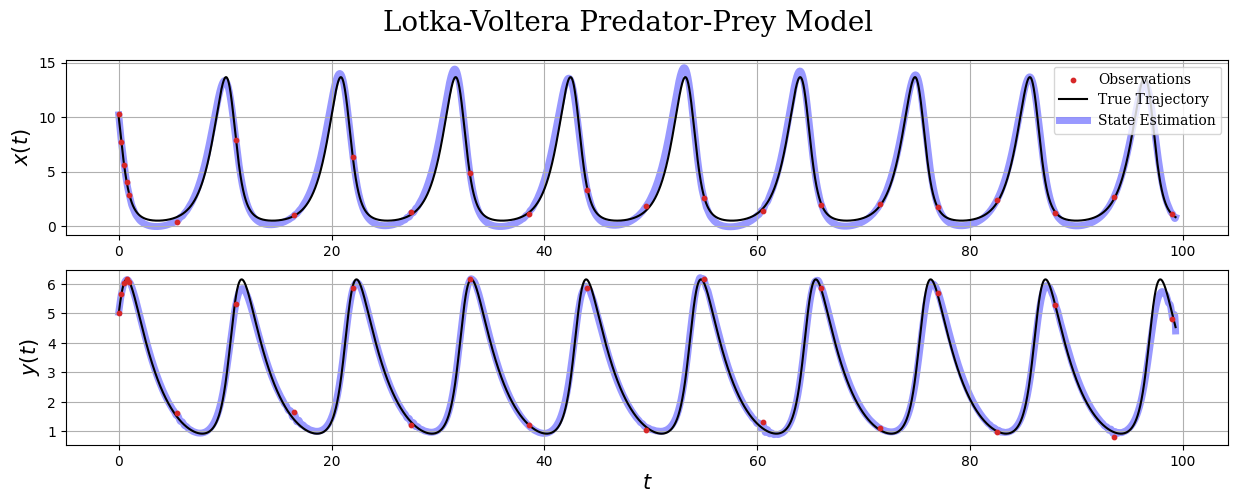

In [20]:
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true


# Set light grey style
# bg_color = "#c1bebe"  # Very light grey
# text_color = 'black'  # Works better on light background

# plt.rcParams.update({
#     'axes.facecolor': bg_color,
#     'figure.facecolor': bg_color,
#     'axes.edgecolor': bg_color,
#     'axes.labelcolor': text_color,
#     'xtick.color': text_color,
#     'ytick.color': text_color,
#     'grid.color': 'grey',
#     'grid.alpha': 0.3,
#     'legend.frameon': False
# })
cutoff = -70
family='serif'
fig, ax = plt.subplots(2,1, figsize=(15,5))
ylabels = [r"$x(t)$", r"$y(t)$"]
for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx],c='tab:red', label='Observations',s=10,zorder=3)
    ax[idx].plot(t_true[:cutoff], x_true[:cutoff,idx], label='True Trajectory',c='black',zorder=2)
    ax[idx].plot(t_true[:cutoff], x_pred[:cutoff,idx], label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)
    ax[idx].grid(True)
    ax[idx].set_ylabel(ylabels[idx], size=15, family=family)
    if idx==0:
        ax[idx].legend(prop={'family':family})
    if idx == 1:
        ax[idx].set_xlabel(r"$t$",size=15, family=family)
plt.suptitle("Lotka-Voltera Predator-Prey Model", family=family,size=20)
plt.savefig(f"lv_noise_{noise}_dt_{dt_train}_t1_{t1}.png")
plt.show()


In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Prey population", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, x_pred[:,1], label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$y$: Predator population", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

In [ ]:
xdot_pred = model.predict(expdata.x_true)
xdot_true = expdata.x_dot

In [ ]:
for i in range(len(xdot_pred.T)):
    plt.plot(t_true, xdot_true[:,i], label='true')
    plt.plot(t_true, xdot_pred[:,i], label='pred', linestyle='--')
    plt.legend()
    plt.show()

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

for idx in range(2):
    # ax[idx].scatter(t_train, x_train[:,idx])
    ax[idx].plot(t_true, x_true[:,i], label='true')
    # plt.plot(t_true, true[:,i])
    ax[idx].plot(t_true, x_pred[:,i], label='pred', linestyle='--')
    ax[idx].legend()



In [ ]:
import jax
from equinox import tree_pprint
tree_pprint(model.traj_model.kernel, short_arrays=False)
k1 = model.traj_model.kernel.kernels[1]


In [ ]:
jax.nn.softplus(k1.raw_lengthscale) + k1.min_lengthscale


# Try Annealed Optimizer

In [ ]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier,
        num_annealing_steps=4,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [ ]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
metrics['xdot_metrics']

In [ ]:
expdata.print()
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Prey population", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, x_pred[:,1], label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$y$: Predator population", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

# E-SINDy